In [157]:
from os import getcwd
from os.path import join, abspath, pardir
from json import dump
import geopandas as gp
from shapely.geometry import LineString
import pandas as pd
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

##### Configs

In [ ]:
parent_dir = abspath(join(getcwd(), pardir))
shape_files_dir = join(parent_dir, "2109_STIB_MIVB_Network")
gps_files_dir = join(parent_dir, "GPS")
line_shape_file = join(shape_files_dir, "ACTU_LINES.shp")
stops_shape_file = join(shape_files_dir, "ACTU_STOPS.shp")

##### Load files

In [ ]:
line_df = gp.read_file(line_shape_file)
stops_df = gp.read_file(stops_shape_file)

##### Method to calculate the distance between two stops for a given transport route

In [ ]:
def calculate_distance_between_stops(stops_data, points):
    if not isinstance(stops_data, dict): raise ValueError("Kindly, pass the stops data with 'stop_id' and 'stop_points'.")
    if not isinstance(points, LineString): raise ValueError("Kindly, pass the correct points data.")
    previous_stop_id, previous_distance, distance = None, None, list()
    for index, stop_id in enumerate(stops_data):
        stop_point = stops_data[stop_id]
        stop_distance = points.project(stop_point)
        if index != 0:
            v = {"from": previous_stop_id, "to": stop_id, "distance": float(stop_distance - previous_distance) }
            distance.append(v)
        previous_stop_id = stop_id
        previous_distance = stop_distance
    return distance

##### Get Distance between stops for all the variants for a given transport

In [ ]:
def get_stop_distances_for_transport(transport, line_df, stops_df):
    lines = line_df.loc[line_df['LIGNE'].isin([transport])]
    stops = stops_df.loc[stops_df['Code_Ligne'].isin([transport])]
    variants = list(line_df['VARIANTE'].unique())
    transport_data = dict()
    for variant in variants:        
        lines_v = lines.loc[lines['VARIANTE'].isin([variant])]
        stops_v = stops.loc[stops['Variante'].isin([variant])]
        
        v_points = list(lines_v['geometry'])[0]
        stops_data_v = dict(zip(stops_v.stop_id, stops_v.geometry))
        
        transport_data[int(variant)] = calculate_distance_between_stops(stops_data=stops_data_v, points=v_points)
        
    return transport_data

##### Get distances between the stops for all buses, trams, metros

In [ ]:
transports = sorted(set(line_df['LIGNE']))
transport_distances = dict()
for transport in transports:
    transport_distances[transport] = get_stop_distances_for_transport(transport=transport, line_df=line_df, stops_df=stops_df)

##### Helper functions for prediction of mode transport

In [128]:
def get_list_threshold(min=1, max=100):
    return [x for x in range(int(min), int(max)) if all(x % t for t in range(2, x))]

def get_spatial_join(df1, df2, threshold_list, column=None, **kwargs):
    if not isinstance(df1, gp.GeoDataFrame): raise ValueError("Kindly, pass a valid geo pandas dataframe.")
    if not isinstance(df2, gp.GeoDataFrame): raise ValueError("Kindly, pass a valid geo pandas dataframe.")
    if (not isinstance(threshold_list, list)) or (not len(threshold_list)): raise ValueError("Kindly, pass a valid threshold list.")
    
    # Make sure both geo-panda dataframes 'df1' & 'df2' have the same coordinate reference system (crs)
    if df1.crs != df2.crs:
        df1 = df1.to_crs(df2.crs)
    
    _threshold_ = float(0)
    df = None
    for threshold in threshold_list:
        df = df2.sjoin_nearest(df1, max_distance=float(threshold), distance_col="distances", **kwargs)
        if not df.empty:
            _threshold_ = threshold
            break
    if (column is None) or (column not in df.columns.to_list()):
        return _threshold_, list()
    else:
        return _threshold_, list(df[column].unique())
    
def get_intersection(list_1, list_2):
    if (not isinstance(list_1, list)) or (not isinstance(list_2, list)): raise ValueError("Kindly, pass a valid list for intersection.")
    
    return list( set(list_1).intersection( set(list_2) ) )

##### Predict the mode of transport for each GPS track

In [171]:
def predict_transport_mode(gps_df, line_df, stops_df, detailed_analysis=False):
    if not isinstance(gps_df, pd.DataFrame): raise ValueError("Kindly, pass the gps track(s) data as a pandas dataframe.")
    if not isinstance(stops_df, gp.GeoDataFrame): raise ValueError("Kindly, pass the stops data as a geo pandas dataframe.")
    if not isinstance(line_df, gp.GeoDataFrame): raise ValueError("Kindly, pass the stops data as a geo pandas dataframe.")
    
    # Get list of all the tracks in the GPS data
    tracks = list(gps_df['TrackId'].unique())
    
    # Max. threshold for max_dist (in meters)
    max_dist_threshold = float(100)
    
    # List of thresholds for lines and stops
    lines_max_dist_threshold = get_list_threshold(1, max_dist_threshold)
    stops_max_dist_threshold = get_list_threshold(5, max_dist_threshold)
    
    # For result
    result = namedtuple('Result', ['track_id', 'mode', 'modes'])
    
    # For each GPS track
    for track in tracks:
        
        # 1. Get 'track' data from gps_df
        track_df = gps_df.loc[gps_df['TrackId'].isin([track])]
        
        # 2. Convert into geo-pandas dataframe with coordinate reference system (crs) of '4326' (WGS 84)
        track_df = gp.GeoDataFrame(track_df, geometry=gp.points_from_xy(track_df['lon'], track_df['lat']), crs=4326)
        
        # 3. Get spatial join with lines
        line_max_dist_threshold, closest_lines = get_spatial_join(track_df, line_df, threshold_list=lines_max_dist_threshold, column="LIGNE")

        # 4. Get spatial join with stops
        stop_max_dist_threshold, closest_stops = get_spatial_join(track_df, stops_df, threshold_list=stops_max_dist_threshold, column="Code_Ligne")
        
        # 5. Get intersection of common modes
        modes = get_intersection(closest_lines, closest_stops)
        
        # Sanity check (if no modes) -> probably the mode is "others"
        if not len(modes):
            result[track] = Result(track_id=track, mode="others", modes=list())
            continue
        
        # 6. For each transport mode, check how close is it to your track
        # for mode in modes:
        fig, ax = plt.subplots(figsize=(15, 15))
        track_df.to_crs(line_df.crs).plot(ax=ax, alpha=0.7, color="pink")
        line_df.loc[line_df['LIGNE'].isin(modes)].plot(ax=ax)
            
        # print("Track:\t{}\tmax_line:\t{}\tmax_stop:\t{}\tModes:\t{}".format(track, line_max_dist_threshold, stop_max_dist_threshold, modes))        

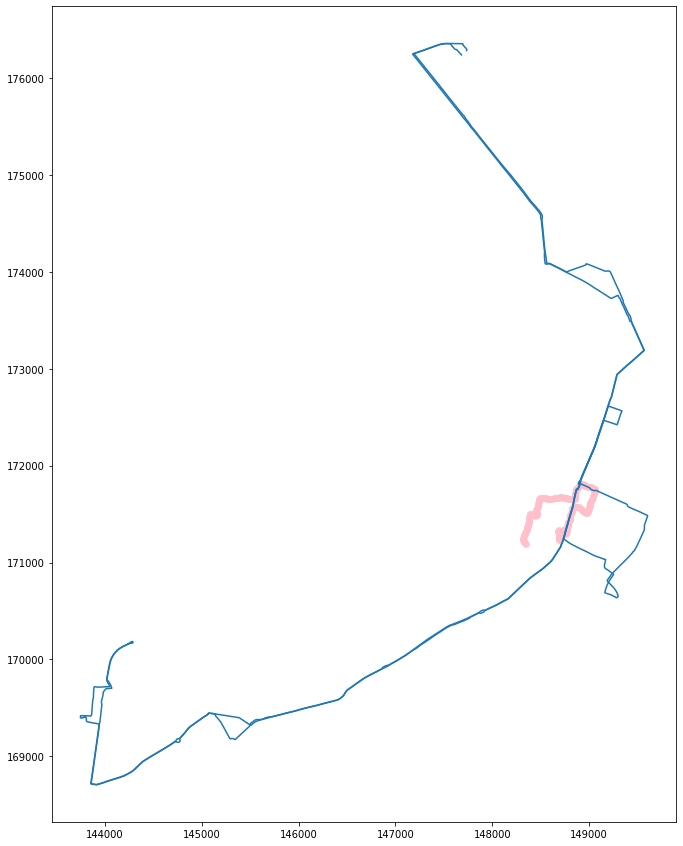

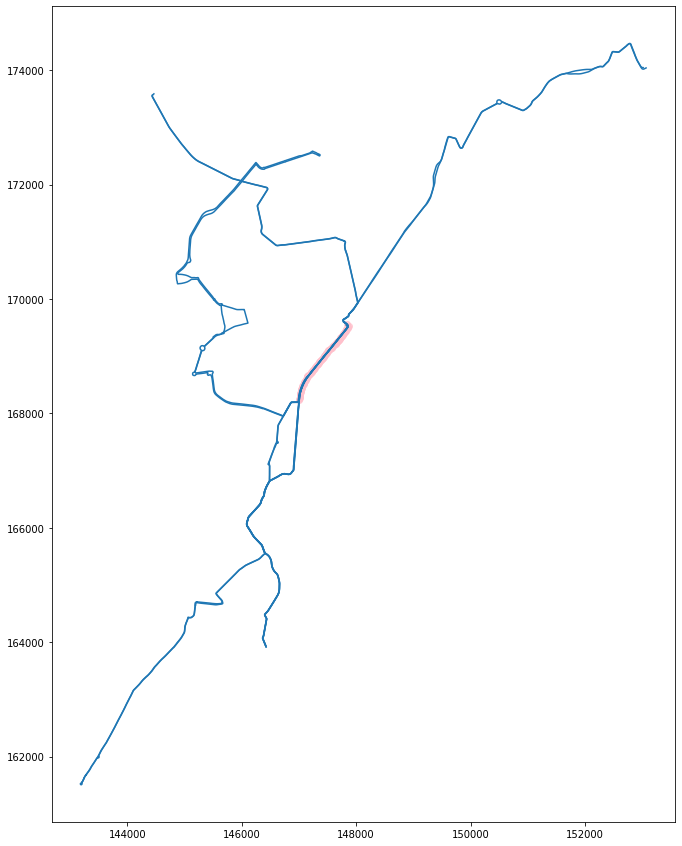

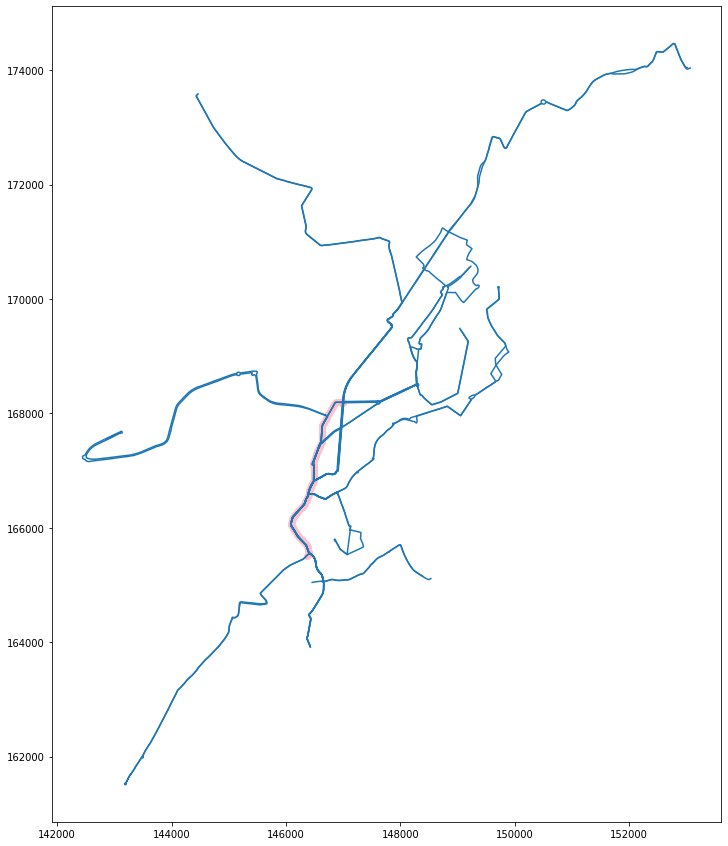

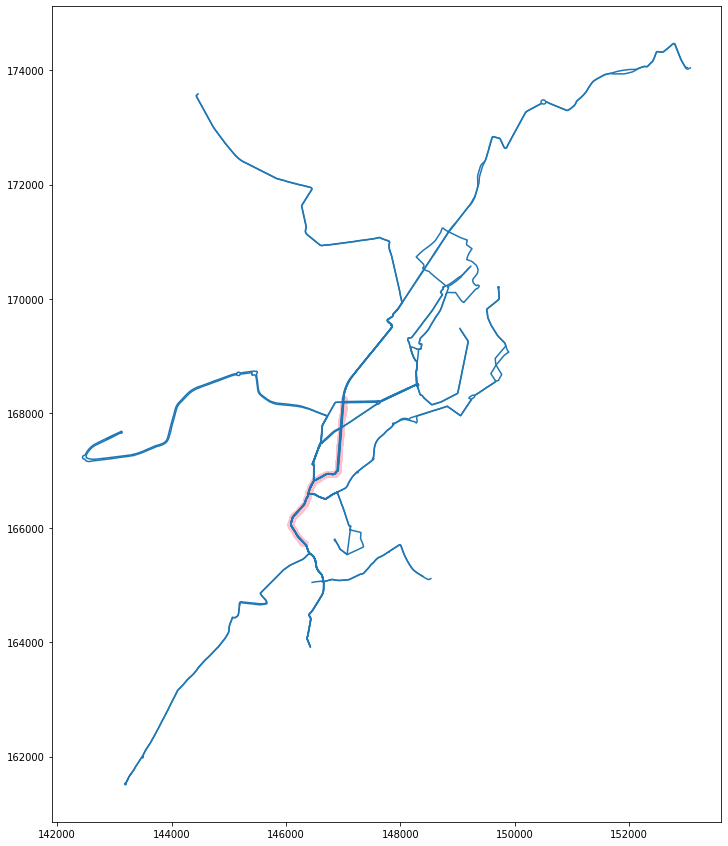

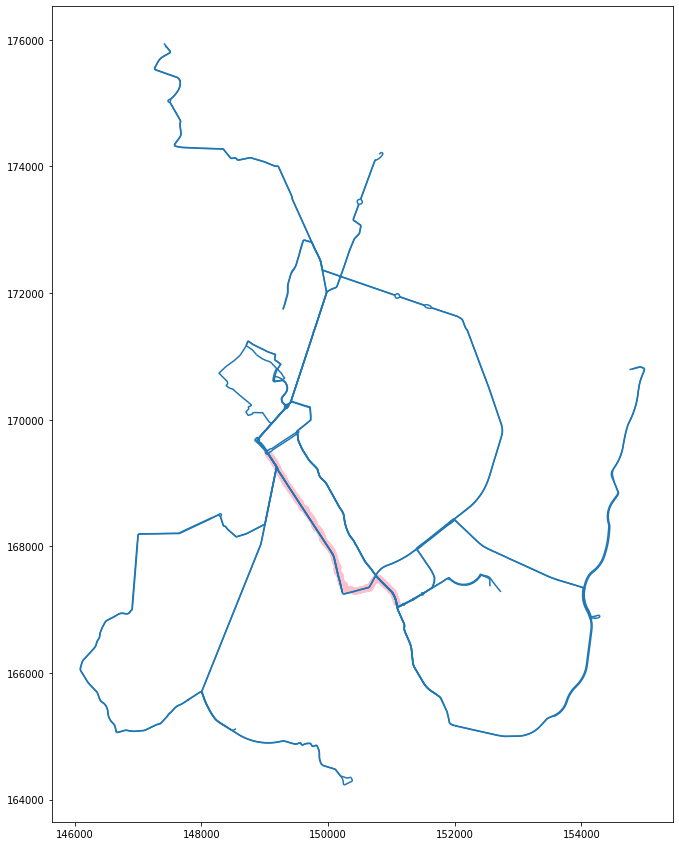

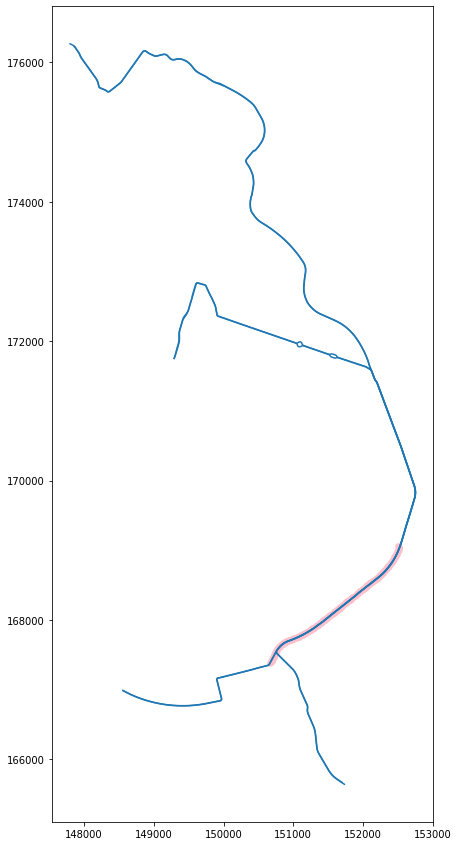

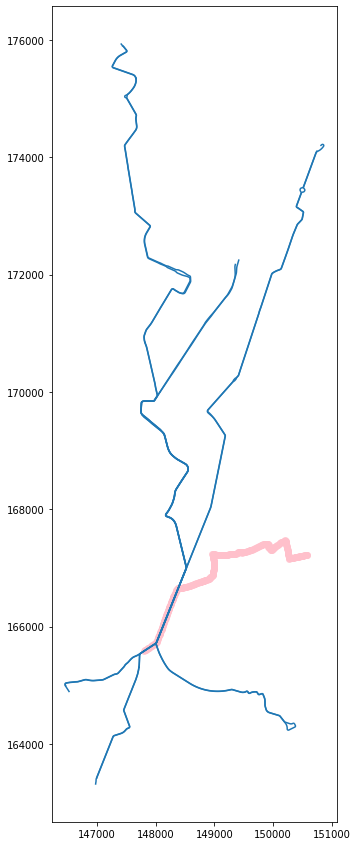

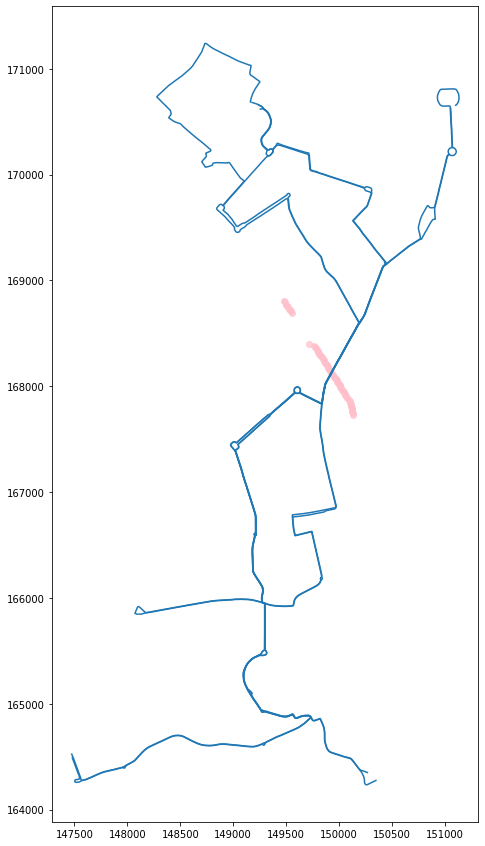

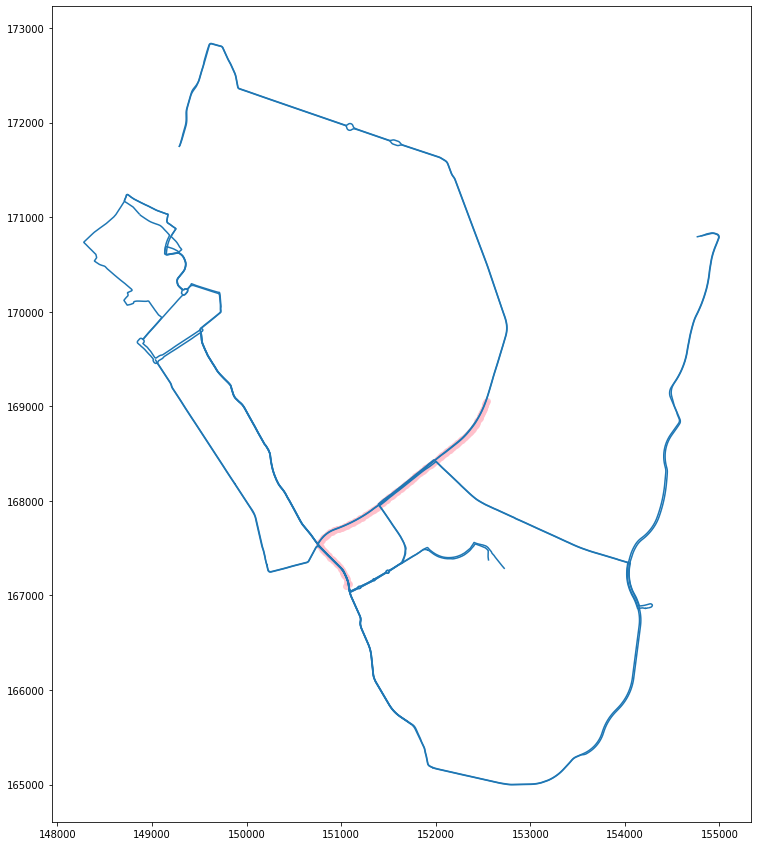

In [172]:
predict_transport_mode(gps_df, line_df, stops_df)

##### Get the GPS Tracks

In [114]:
gps_df = pd.read_csv(join(gps_files_dir, "GPStracks.csv"))

In [115]:
gps_df.head()

,TrackId,lat,lon,time
0,1,50.851152,4.345326,2021-11-16T08:35:24Z
1,1,50.851235,4.345191,2021-11-16T08:35:45Z
2,1,50.851328,4.345069,2021-11-16T08:35:48Z
3,1,50.851403,4.344988,2021-11-16T08:35:51Z
4,1,50.851500,4.344920,2021-11-16T08:35:55Z


In [116]:
tracks = list(gps_df['TrackId'].unique())

In [117]:
track_df = gps_df.loc[gps_df['TrackId'].isin([tracks[1]])]

In [118]:
track_df = gp.GeoDataFrame(track_df, geometry=gp.points_from_xy(track_df['lon'], track_df['lat']), crs=4326)

In [160]:
track_df = track_df.to_crs(line_df.crs)

In [173]:
track_df.explore()

In [ ]:
t1_line_df = line_df.sjoin_nearest(track_df, max_distance=float(1), distance_col="distances")

In [ ]:
t1_line_df.explore()

In [ ]:
list(t1_line_df['LIGNE'].unique())

In [112]:
'LIGNE' in t1_line_df.columns.to_list()

True

In [108]:
t1_stop_df = stops_df.sjoin_nearest(track_df.to_crs(stops_df.crs), max_distance=float(5), distance_col="distances")
t1_stop_df.head()

,Code_Ligne,Variante,succession,stop_id,descr_fr,descr_nl,alpha_fr,alpha_nl,coord_x,coord_y,mode,numero_lig,terminus,geometry,index_right,TrackId,lat,lon,time,distances
962,049b,2,24,5159,WIELS,WIELS,Wiels,Wiels,147011.0,168273.0,B,49,GARE DU MIDI,POINT (147011.000 168273.000),290,3,50.824843,4.326357,2021-11-18T09:23:52Z,4.430379
1011,050b,2,20,5159,WIELS,WIELS,Wiels,Wiels,147011.0,168273.0,B,50,GARE DU MIDI,POINT (147011.000 168273.000),290,3,50.824843,4.326357,2021-11-18T09:23:52Z,4.430379
3576,032t,2,16,5159F,WIELS,WIELS,Wiels,Wiels,147010.0,168273.0,T,32,DA VINCI,POINT (147010.000 168273.000),290,3,50.824843,4.326357,2021-11-18T09:23:52Z,4.945351
3959,082t,2,16,5159F,WIELS,WIELS,Wiels,Wiels,147010.0,168273.0,T,82,GARE DE BERCHEM,POINT (147010.000 168273.000),290,3,50.824843,4.326357,2021-11-18T09:23:52Z,4.945351


In [109]:
t1_stop_df.empty

False

In [ ]:
t1_stop_df.explore()

In [ ]:
list(t1_stop_df['Code_Ligne'].unique())

In [ ]:
list(t1_line_df['LIGNE'].unique())

In [84]:
type(stops_df)

geopandas.geodataframe.GeoDataFrame

In [164]:
track_df.crs == line_df.crs

True

In [148]:
line_max, line_track = get_spatial_join(track_df, line_df, [1, 2], 'LIGNE')

In [149]:
stop_max, stop_track = get_spatial_join(track_df, stops_df, [1, 2, 5], 'Code_Ligne')

In [151]:
stop_track

['049b', '050b', '032t', '082t']

In [155]:
line_track

['032t', '082t', '048b', '081t', '049b', '050b']

In [153]:
modes = get_intersection(line_track, stop_track)

In [154]:
modes

['049b', '032t', '050b', '082t']

In [166]:
line_df.head()

,LIGNE,VARIANTE,COLOR_HEX,Date_debut,Date_fin,geometry
0,001m,1,#C4008F,01/09/2021,06/03/2022,"LINESTRING Z (146633.500 170956.400 0.000, 146..."
1,001m,2,#C4008F,01/09/2021,06/03/2022,"LINESTRING Z (156746.700 170167.000 0.000, 156..."
2,002m,1,#F57000,01/09/2021,06/03/2022,"LINESTRING Z (147305.500 172526.900 0.000, 147..."
3,002m,2,#F57000,01/09/2021,06/03/2022,"LINESTRING Z (147370.500 172498.500 0.000, 147..."
4,003t,1,#B5BA05,01/09/2021,06/03/2022,"LINESTRING Z (148550.000 176641.300 0.000, 148..."


<AxesSubplot:>

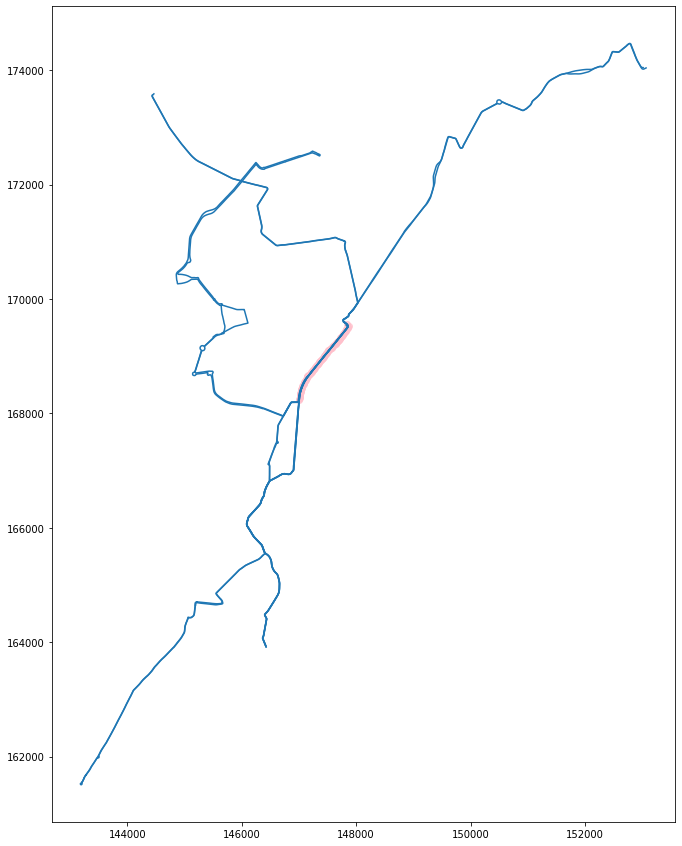

In [168]:
fig, ax = plt.subplots(figsize=(15, 15))
track_df.plot(ax=ax, alpha=0.7, color="pink")
line_df.loc[line_df['LIGNE'].isin(modes)].plot(ax=ax)
# line_df.plot(ax=ax)